In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import GridSearchCV, cross_val_score

from sklearn import metrics
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score 
from sklearn.metrics import plot_confusion_matrix 
from sklearn.metrics import roc_auc_score
    
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc
from matplotlib.pylab import rc, plot
import itertools   
import scikitplot as skplt 
from sklearn.tree import plot_tree

In [3]:
df = pd.read_excel('./CardiologyCategorical.xls') 
df.rename(columns={"chest pain type": "chest_pain_type", "blood pressure": "blood_pressure", "Fasting blood sugar <120" : 'Fasting_blood_sugar_<120', 'resting ecg': 'resting_ecg', 'maximum heart rate' : 'maximum_heart_rate', '#colored vessels' : 'colored_vessels'}, inplace=True)

# Preparing data

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 303 entries, 0 to 302
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   class                     303 non-null    object 
 1   sex                       303 non-null    object 
 2   chest_pain_type           303 non-null    object 
 3   blood_pressure            303 non-null    int64  
 4   cholesterol               303 non-null    int64  
 5   Fasting_blood_sugar_<120  303 non-null    bool   
 6   resting_ecg               303 non-null    object 
 7   maximum_heart_rate        303 non-null    int64  
 8   angina                    303 non-null    bool   
 9   peak                      303 non-null    float64
 10  slope                     303 non-null    object 
 11  colored_vessels           303 non-null    int64  
 12  thal                      303 non-null    object 
dtypes: bool(2), float64(1), int64(4), object(6)
memory usage: 26.8+ K

In [5]:
df.dropna(inplace=True) # drop null values
df.shape # Matrix Shape

(303, 13)

In [6]:
df['chest_pain_type'].value_counts()

 Asymptomatic      143
NoTang              87
Abnormal Angina     50
Angina              23
Name: chest_pain_type, dtype: int64

In [7]:
df.head()

,class,sex,chest_pain_type,blood_pressure,cholesterol,Fasting_blood_sugar_<120,resting_ecg,maximum_heart_rate,angina,peak,slope,colored_vessels,thal
0,Sick,Male,Asymptomatic,130,206,False,Hyp,132,True,2.4,Flat,2,Rev
1,Healthy,Male,Abnormal Angina,130,266,False,Normal,171,False,0.6,Up,0,Normal
2,Healthy,Male,Angina,110,211,False,Hyp,144,True,1.8,Flat,0,Normal
3,Sick,Male,Asymptomatic,130,254,False,Hyp,147,False,1.4,Flat,1,Rev
4,Sick,Male,Asymptomatic,140,203,True,Hyp,155,True,3.1,Down,0,Rev


# Label Encoding


In [8]:
# Create list of unique values
chest_pain_type = tuple(df['chest_pain_type'].value_counts().index)
thal = tuple(df['thal'].value_counts().index)
slope = tuple(df['slope'].value_counts().index)
resting_ecg = tuple(df['resting_ecg'].value_counts().index)

#create temp dataframe
df_chest = pd.DataFrame(df, columns=['chest_pain_type'])
df_thal = pd.DataFrame(df, columns=['thal'])
df_slope = pd.DataFrame(df, columns=['slope'])
df_resting_ecg = pd.DataFrame(df, columns=['resting_ecg'])


for col in ['thal', 'slope', 'resting_ecg']:
    df[col] = df[col].astype('category')

In [9]:
df_slope = pd.get_dummies(df_slope, columns=['slope'], prefix=["slope:"], dtype='int64')
df_resting_ecg = pd.get_dummies(df_resting_ecg, columns=['resting_ecg'], prefix=["resting_ecg:"], dtype='int64')

# merge with main df bridge_df on key values
df = df.join(df_slope)
df = df.join(df_resting_ecg)

In [10]:
df.drop(['slope'], axis=1, inplace=True)
df.drop(['resting_ecg'], axis=1, inplace=True)

In [11]:
# data mapping to int values
state =  {"Healthy": 0, 'Sick': 1,}
df['class'] = df['class'].map(state)

d_sex = {"Male": 1, "Female": 0,}
df['sex'] = df['sex'].map(d_sex)

sugar = {True: 1, False: 0,}
df['Fasting_blood_sugar_<120'] = df['Fasting_blood_sugar_<120'].map(sugar)

angina = {True: 1, False: 0,}
df['angina'] = df['angina'].map(angina)


thal = {'Normal': 1, 'Fix': 2, 'Rev': 3}
df['thal'] = df['thal'].map(thal)


chest_pain_type = {' Asymptomatic': 0, 'NoTang': 1, 'Abnormal Angina': 2, 'Angina': 3}
df['chest_pain_type'] = df['chest_pain_type'].map(chest_pain_type)

In [12]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 303 entries, 0 to 302
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype   
---  ------                    --------------  -----   
 0   class                     303 non-null    int64   
 1   sex                       303 non-null    int64   
 2   chest_pain_type           303 non-null    int64   
 3   blood_pressure            303 non-null    int64   
 4   cholesterol               303 non-null    int64   
 5   Fasting_blood_sugar_<120  303 non-null    int64   
 6   maximum_heart_rate        303 non-null    int64   
 7   angina                    303 non-null    int64   
 8   peak                      303 non-null    float64 
 9   colored_vessels           303 non-null    int64   
 10  thal                      303 non-null    category
 11  slope:_Down               303 non-null    int64   
 12  slope:_Flat               303 non-null    int64   
 13  slope:_Up                 303 non-null    int64   

In [13]:
df.head()

,class,sex,chest_pain_type,blood_pressure,cholesterol,Fasting_blood_sugar_<120,maximum_heart_rate,angina,peak,colored_vessels,thal,slope:_Down,slope:_Flat,slope:_Up,resting_ecg:_Abnormal,resting_ecg:_Hyp,resting_ecg:_Normal
0,1,1,0,130,206,0,132,1,2.4,2,3,0,1,0,0,1,0
1,0,1,2,130,266,0,171,0,0.6,0,1,0,0,1,0,0,1
2,0,1,3,110,211,0,144,1,1.8,0,1,0,1,0,0,1,0
3,1,1,0,130,254,0,147,0,1.4,1,3,0,1,0,0,1,0
4,1,1,0,140,203,1,155,1,3.1,0,3,1,0,0,0,1,0


# Train/Test split

In [14]:
# Splitting for parameters and target class
y = df['class'] # target class values
X = df.drop('class', axis = 1) # Parameters

In [15]:
# Splitting to train/test dataset with startification by target class. 
X_train, X_holdout, y_train, y_holdout,  = train_test_split(X, y, test_size=0.3,
                                                          random_state=10, stratify=y) 

In [16]:
# Train test shape
X_train.shape, X_holdout.shape, y_train.shape, y_holdout.shape

((212, 16), (91, 16), (212,), (91,))

In [17]:
tree = DecisionTreeClassifier(random_state=10) # Decision Tree with default hyperparameters

In [18]:
%%time
tree.fit(X_train, y_train)

Wall time: 5 ms


DecisionTreeClassifier(random_state=10)

In [19]:
# Cross Validation score of Decision Tree with default hyperparameters
print(cross_val_score(tree, X_train, y_train, cv=10))

[0.54545455 0.81818182 0.80952381 0.76190476 0.80952381 0.71428571
 0.66666667 0.76190476 0.76190476 0.85714286]


In [20]:
# Decision Tree with default hyperparameters on holdout data
print(metrics.accuracy_score(y_holdout, tree.predict(X_holdout)))

0.7362637362637363


# Hyperparameter Tuning

In [21]:
# GridSearch of best hyperparameters
tree_params = {'criterion': ('gini', "entropy"), 
               'min_samples_leaf': range(1,15),'max_depth': range(1,10)} 
tree_grid = GridSearchCV(tree, tree_params,
                         cv=10, n_jobs=-1,
                        verbose=True) 

In [22]:
%%time
tree_grid.fit(X_train, y_train)

Fitting 10 folds for each of 252 candidates, totalling 2520 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  68 tasks      | elapsed:    2.8s


Wall time: 7.03 s


[Parallel(n_jobs=-1)]: Done 2508 tasks      | elapsed:    6.9s
[Parallel(n_jobs=-1)]: Done 2520 out of 2520 | elapsed:    6.9s finished


GridSearchCV(cv=10, estimator=DecisionTreeClassifier(random_state=10),
             n_jobs=-1,
             param_grid={'criterion': ('gini', 'entropy'),
                         'max_depth': range(1, 10),
                         'min_samples_leaf': range(1, 15)},
             verbose=True)

In [23]:
tree_grid.best_estimator_ # Best Hyperparameters 

DecisionTreeClassifier(criterion='entropy', max_depth=3, min_samples_leaf=8,
                       random_state=10)

In [24]:
(cross_val_score(tree_grid.best_estimator_, X_train, y_train, cv=10)) # Cross Validation score (10х) 

array([0.81818182, 0.95454545, 0.85714286, 0.95238095, 0.85714286,
       0.71428571, 0.85714286, 0.9047619 , 0.80952381, 0.95238095])

In [25]:
# Decision Tree with best hyperparameters on holdout data
metrics.accuracy_score(y_holdout, tree_grid.best_estimator_.predict(X_holdout)) 

0.7802197802197802

In [26]:
#Prediction
y_pred = tree_grid.best_estimator_.predict(X_holdout)

### Характеристики бинарного классификатора
Основываясь на данной таблице, можно ввести несколько величин, характеризующих бинарный классификатор:
$$rec = TPR = \frac{TP}{TP + FN},\quad SPC = \frac{TN}{TN + FP},\quad prec = PPV = \frac{TP}{TP + FP},\quad FPR = 1 - SPC,$$

$$ACC = \frac{TP + TN}{TP + TN + FP + FN},\quad F1 = 2\frac{PPV\cdot TRP}{PPV + TPR}.$$

Полнота $TPR$ (True positive rate, recall, sensitivity) - доля верно классифицированных положительных примеров среди всех положительных примеров.

Специфичность $SPC$ (Specificity, true negative rate) - доля верно классифицированных отрицательных примеров среди всех отрицательных примеров.

Точность $PPV$ (Positive predictive value, precision) - доля верно классифицированных положительных примеров среди всех примеров, классифицированных положительно.

$FPR$ (False positive rate) - доля ошибочно классифицированных отрицательных примеров среди всех отрицательных примеров.

$ACC$ (Accuracy) - доля верно классифицированных примеров среди всех примеров. Основная характеристика качества классификации.

$F1$ (F1-measure) - среднее гармоническое точности и полноты. Позволяет учесть обе характеристики одновременно.

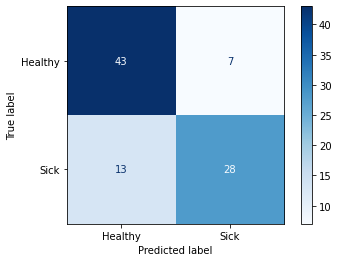

Classification Report:
              precision    recall  f1-score   support

           0       0.77      0.86      0.81        50
           1       0.80      0.68      0.74        41

    accuracy                           0.78        91
   macro avg       0.78      0.77      0.77        91
weighted avg       0.78      0.78      0.78        91

Accuracy: 0.7802197802197802


In [27]:
#Confusion Matrix:
plot_confusion_matrix(tree_grid.best_estimator_, X_holdout, y_holdout, cmap = plt.cm.Blues, display_labels = ['Healthy', 'Sick'] )
plt.show()

In [ ]:
result1 = classification_report(y_holdout, y_pred) # Classification Report
print("Classification Report:",)
print (result1)

result2 = accuracy_score(y_holdout,y_pred) # accuracy score
print("Accuracy:",result2)

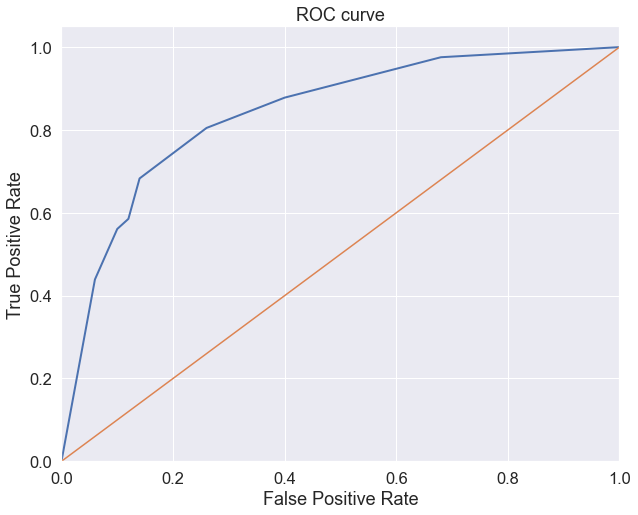

0.8400000000000001


In [28]:
# ROC curve graph

sns.set(font_scale=1.5)
sns.set_color_codes("muted")

plt.figure(figsize=(10, 8))
fpr, tpr, thresholds = roc_curve(y_holdout, tree_grid.best_estimator_.predict_proba(X_holdout)[:,1], pos_label=1)
lw = 2
plt.plot(fpr, tpr, lw=lw, label='ROC curve ')
plt.plot([0, 1], [0, 1])
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.savefig("ROC.png")
plt.show()


# ROC AUC score
y_score = tree_grid.best_estimator_.predict_proba(X_holdout)[:,1]
print(roc_auc_score(y_holdout, y_score))

<AxesSubplot:title={'center':'Cumulative Gains Curve'}, xlabel='Percentage of sample', ylabel='Gain'>

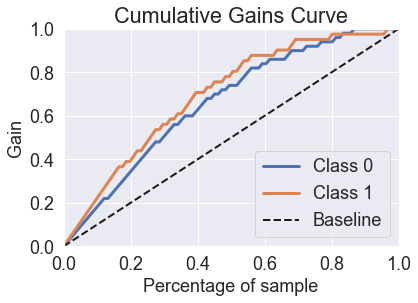

In [29]:
# Prediction probabilities
predicted_probabilities = tree_grid.best_estimator_.predict_proba(X_holdout)

# Gain-curve
skplt.metrics.plot_cumulative_gain(y_holdout, predicted_probabilities)

<AxesSubplot:title={'center':'Lift Curve'}, xlabel='Percentage of sample', ylabel='Lift'>

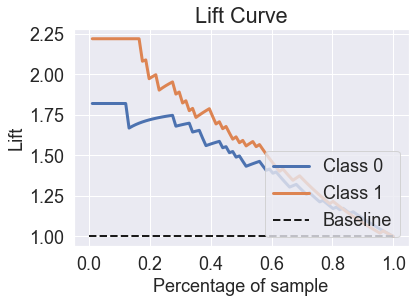

In [30]:
# Lift-curve
skplt.metrics.plot_lift_curve(y_holdout, predicted_probabilities)

<AxesSubplot:title={'center':'Feature Importance'}>

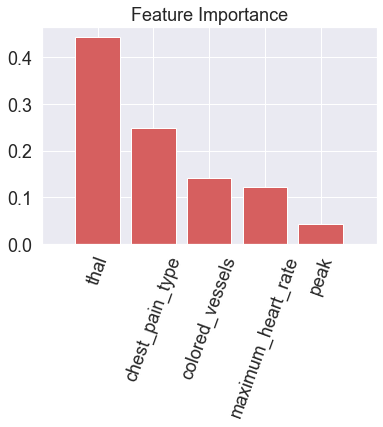

In [31]:
# Feature Importance
skplt.estimators.plot_feature_importances(tree_grid.best_estimator_, title='Feature Importance', feature_names=X_holdout.columns, 
                                          max_num_features=5, 
                                          order='descending', x_tick_rotation=70,
                                          ax=None, figsize=None, title_fontsize='medium', text_fontsize='medium')